In [1]:
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_custom_penalty as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [72]:
#robot initialize
l1 = 0.3 
l2 = 0.2
m1 = 3
m2 = 2
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[0],[.12]],dtype=dtype)
#xinit = torch.tensor([[0],[3]],dtype=dtype)
xfinal = torch.tensor([[0],[.4]],dtype=dtype)
#xinit = torch.tensor([[-3],[0]],dtype=dtype)
#xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
xpoints = np.array([1.9482175,1.9655874,1.2334888,0.84806216,0.5899877 ,1.39479113])
ypoints = np.array([2.300524 ,1.5707964,1.8234766,2.4188585 , 1.8234766,.6707964])
#xpoints = np.array([  2.5,1.5,1 ,1.5,2.5])
#ypoints = np.array([  0.5,1  ,1.5,2  ,2.5])
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 2000
V_size = 500
V_hidden_sizes = [V_size, V_size]
fhat_hidden_sizes = [fhat_size,fhat_size]
tol = 0.01
alpha = 0.01
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 100000
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

# Ploting trajectory

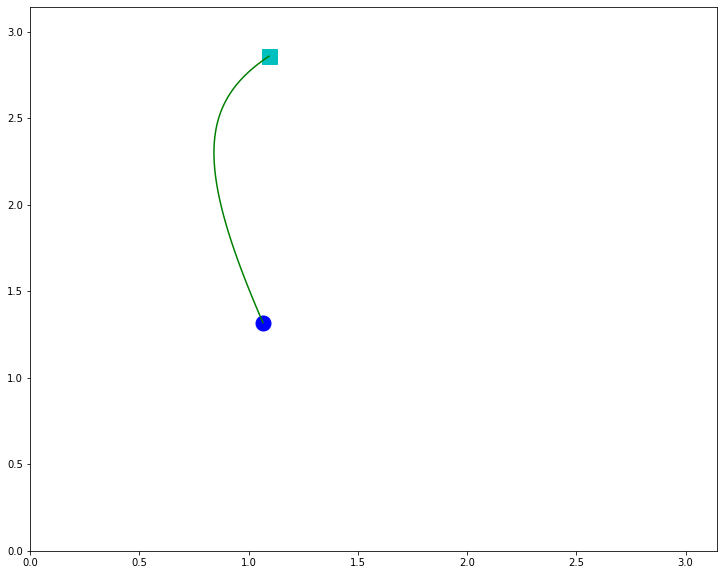

In [73]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

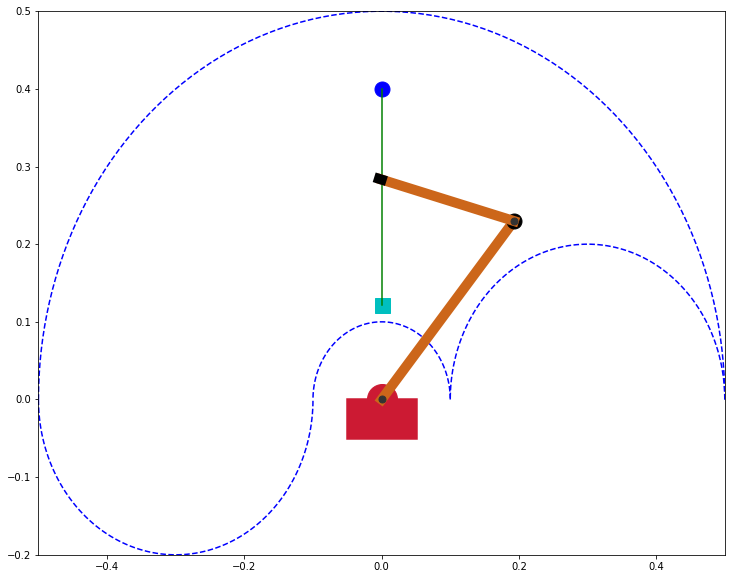

In [74]:
theta1 = qtraj[0,50] #xpoints[2]
theta2 = qtraj[1,50]#ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [75]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [79]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 6256, loss = 0.0003830686, loss_b = 0.0, loss_t = 0.0003830686                    . .     ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

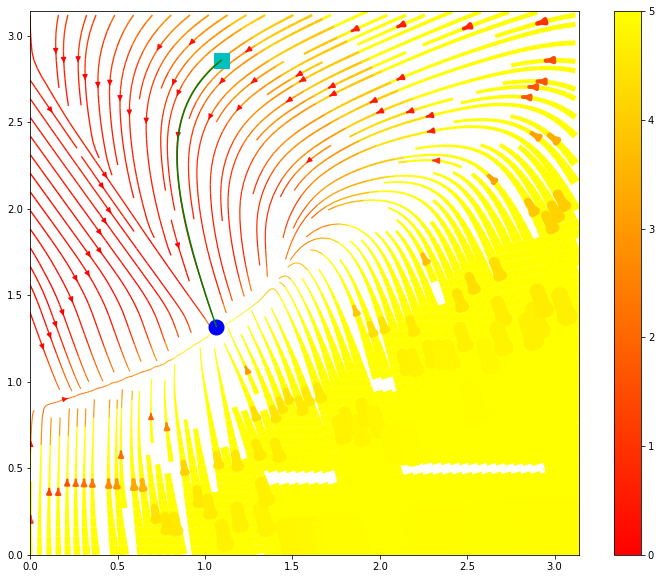

In [80]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0a.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

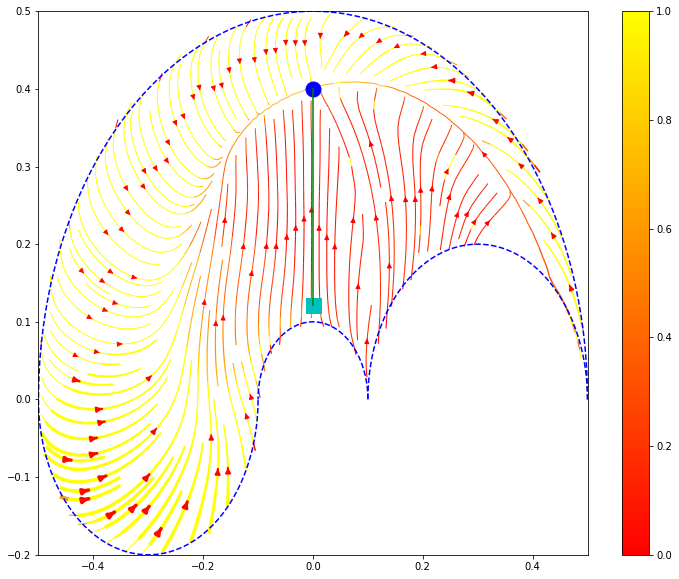

In [81]:
plt_.plot_f_taskspace('task_plot_noreg_0307_cmax1a.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)

## weight norm decay

In [50]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [51]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 7967, loss = 0.00034580767, loss_b = 0.0, loss_t = 0.00034580767                    .   ... ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [82]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 10000, loss = 8.1802005e-05, loss_b = 0.0, loss_t = 8.1802005e-05                    .     . . ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

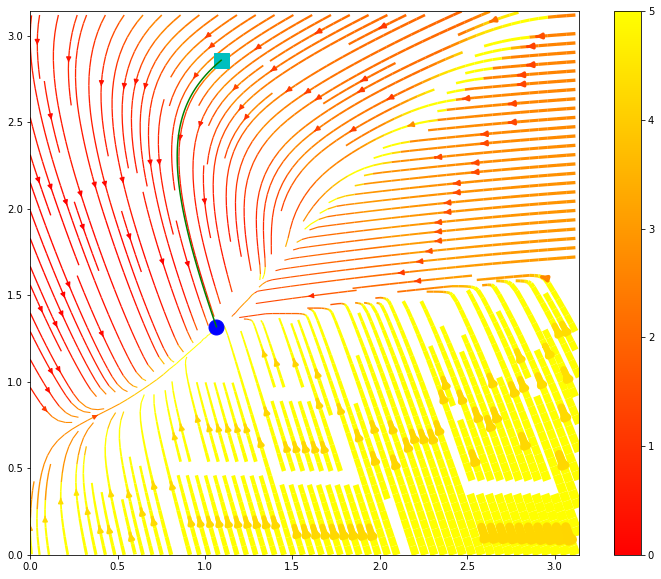

In [83]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_wreg_0307_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

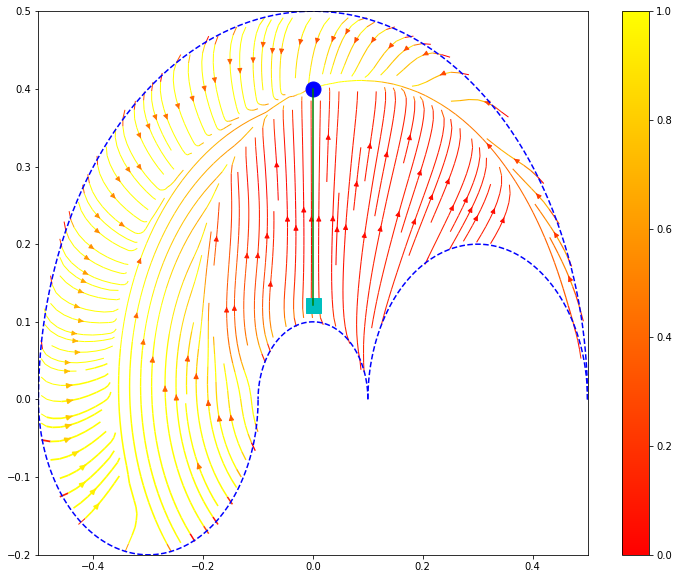

In [84]:
plt_.plot_f_taskspace('task_plot_wreg0307_cmax1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)

# Euclidean Regularization

In [64]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [65]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 3280, loss = 0.0035274816, loss_b = 0.0, loss_t = 0.0035274816                    .       ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

In [62]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 8485, loss = 0.00062496215, loss_b = 0.0018520562, loss_t = 0.00062153203                    .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

KeyboardInterrupt: 

In [85]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 3e-5,epoch=100, batch_size = 40,penalty_mode = mode)

 epoch = 11 i = 246, loss = 5765.4355, total_loss = 5766.2314, loss_b = 0.0, loss_t = 0.00012256103, loss_reg = 5.906807, loss_reg_total =  6.7037616           ..     . ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

KeyboardInterrupt: 

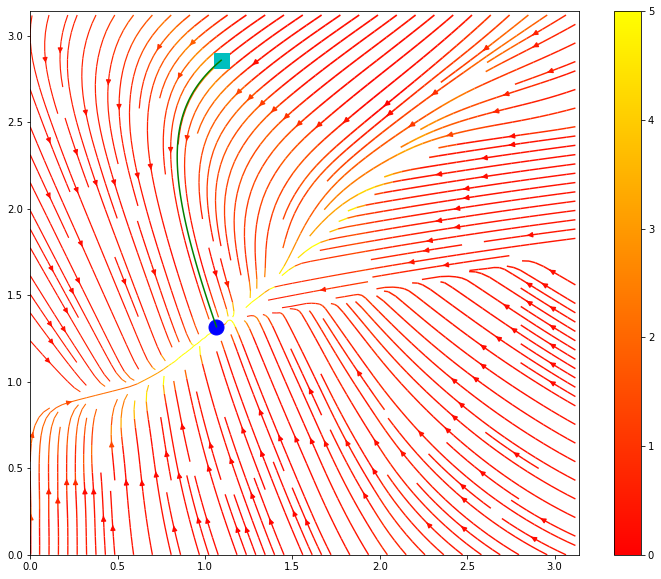

In [86]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_Ereg_0307.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

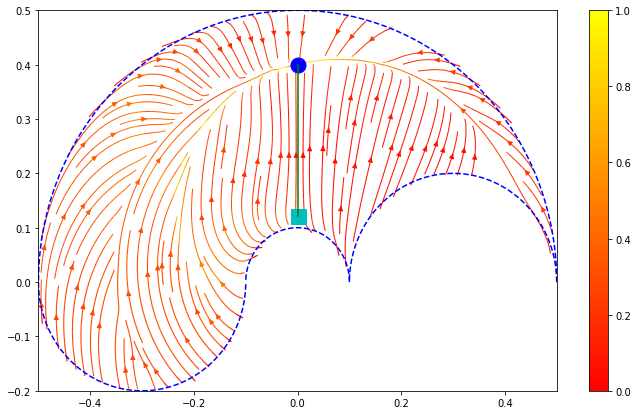

In [91]:
plt_.plot_f_taskspace('task_plot_Ereg_0307_cmax1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)

# Kinematic Regularization

In [18]:
# initialization

penalty = 5000
penalty_boundary = 100000
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [19]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 258, loss = 0.005959592, loss_b = 0.0, loss_t = 0.005959592                    . .       .                                                                                                                                                                                                                                                         

KeyboardInterrupt: 

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [93]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
penalty = 5
penalty_boundary = 100
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-5,epoch=150, batch_size = 40,penalty_mode = 2)

 epoch = 26 i = 17, loss = 5.782146, total_loss = 5.822003, loss_b = 0.00018578068, loss_t = 0.00018612077, loss_reg = 0.021022364, loss_reg_total =  0.06087143           .. ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

KeyboardInterrupt: 

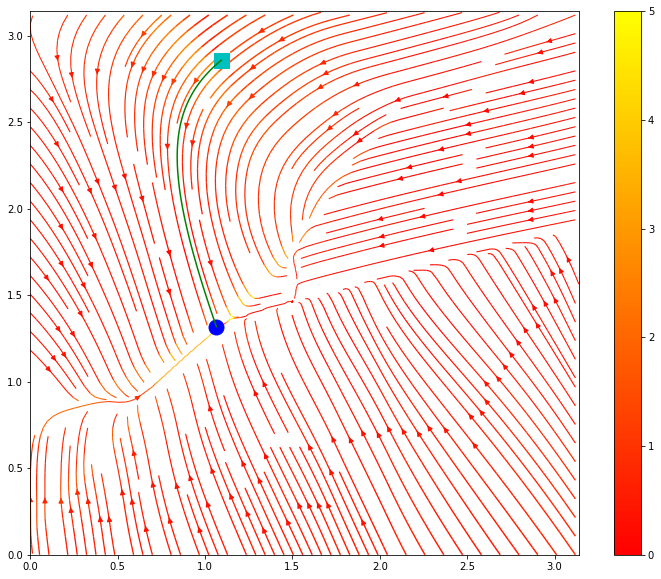

In [96]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kmreg_0307.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

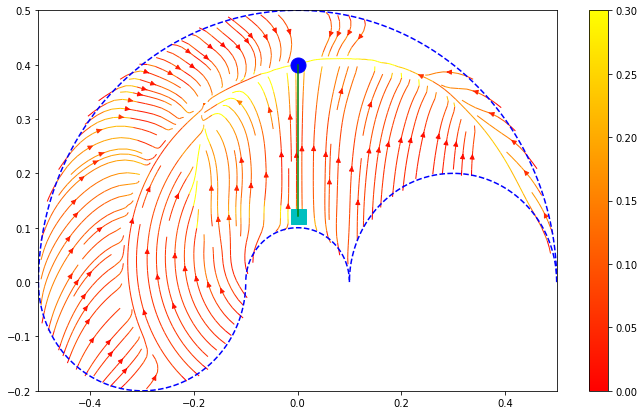

In [101]:
plt_.plot_f_taskspace('task_plot_kinreg_0307_03.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=0.3)

# Kinetic Regularization

In [25]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [26]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 5357, loss = 0.00067470147, loss_b = 0.0, loss_t = 0.00067470147                    .  .. ..  ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [104]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
penalty = 50
penalty_boundary = 1000
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-5,epoch=100, batch_size = 40,penalty_mode = 2)

 epoch = 11 i = 157, loss = 11514.142, total_loss = 11514.136, loss_b = 0.0, loss_t = 2.3226494e-05, loss_reg = 0.054271165, loss_reg_total =  0.07635923           ..    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

KeyboardInterrupt: 

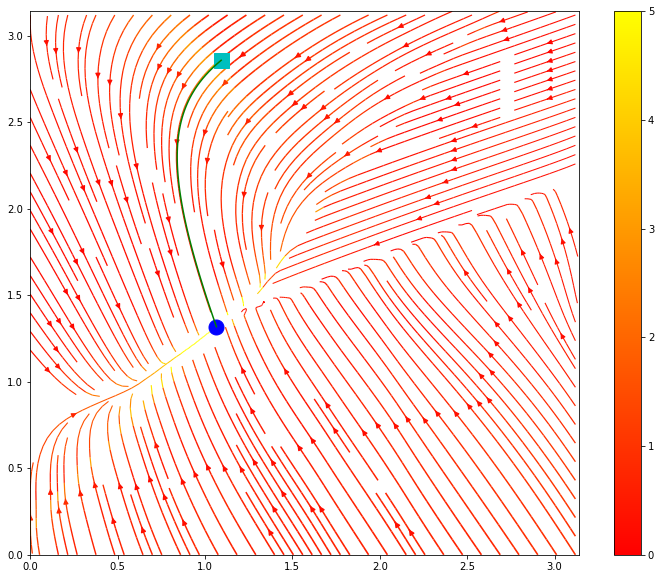

In [105]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_kreg_0307.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

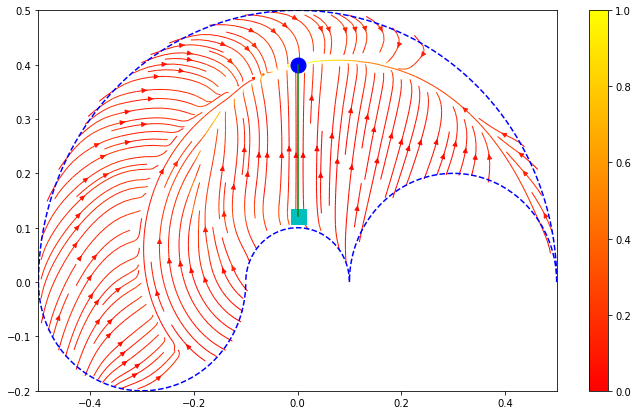

In [108]:
plt_.plot_f_taskspace('task_plot_kreg_0307_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=1)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

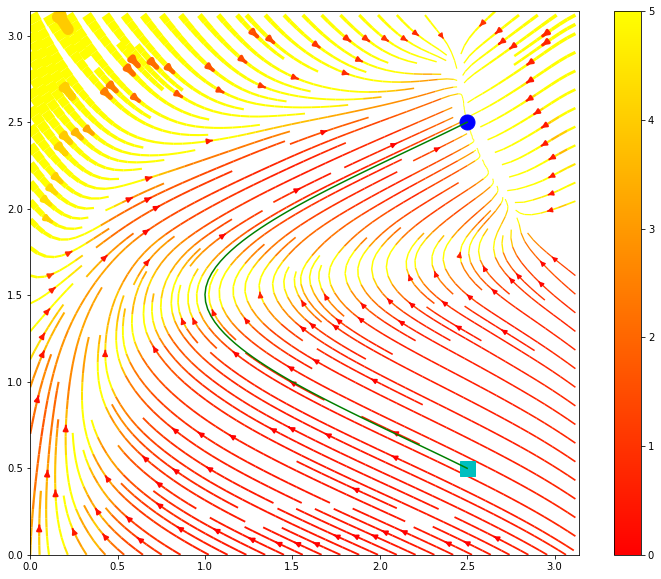

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

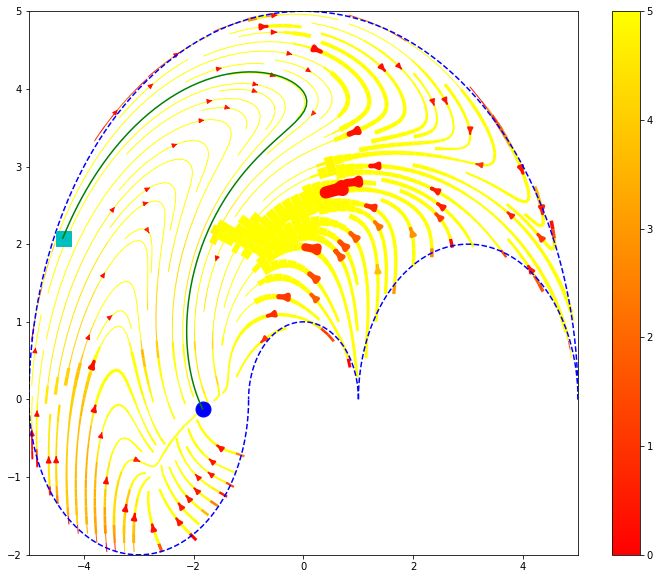

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'